## Data augmentation

- Artificiellt skapar bilder
- Slumpmässigt:
    - rotera till en viss grad
    - translatera slumpmässigt
    - spegla
    - shear
    - ...

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
from tensorflow.keras.datasets.mnist import load_data

(X_train, y_train), (X_test, y_test) = load_data()

y_train = y_train.ravel()
y_test = y_test.ravel()

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [5]:
X_train = X_train.astype("float32") / 255
X_test = X_test.astype("float32") / 255

print(f"{X_train.max()=}, {X_train.min()=}")

X_train.max()=1.0, X_train.min()=0.0


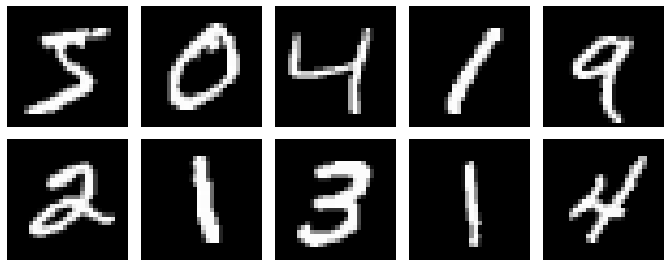

In [6]:
def display_images(data, nrows = 2, ncols = 5, figsize = (12,4)):
    fig, axes = plt.subplots(nrows, ncols, figsize = figsize)

    for i, ax in enumerate(axes.flatten()):
        ax.imshow(data[i, :, :], cmap = "gray")
        ax.axis("off")

    fig.subplots_adjust(wspace = 0, hspace = .1, bottom = 0)

display_images(X_train)

In [7]:
from sklearn.model_selection import train_test_split

X_train_val, X_val, y_train_val, y_val = train_test_split(X_train, y_train, test_size = 1/6, random_state = 42)

X_train_val = X_train_val[:,:,:, None]
X_train = X_train[:,:,:, None]
X_val = X_val[:,:,:, None]
X_test = X_test[:,:,:, None]

X_train_val.shape

(50000, 28, 28, 1)

In [24]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_image_generator = ImageDataGenerator(
    #rotation_range = 90,
    shear_range = .05,
    zoom_range = .1,
    #horizontal_flip = True,
    height_shift_range = .2,
    width_shift_range = .2
)

# don't augment valiadtion and test data

test_image_generator = ImageDataGenerator()

train_val_generator = train_image_generator.flow(X_train_val[0:2], y_train_val[0:2], batch_size = 32)

val_generator = test_image_generator.flow(X_val, y_val, batch_size = 32)

train_val_generator, val_generator

(<keras.preprocessing.image.NumpyArrayIterator at 0x2cd89b880>,
 <keras.preprocessing.image.NumpyArrayIterator at 0x2cd89b850>)

In [25]:
print(len(train_val_generator.next()))
print(train_val_generator.next()[0].shape) # 32 samples in a batch

2
(2, 28, 28, 1)


IndexError: index 2 is out of bounds for axis 0 with size 2

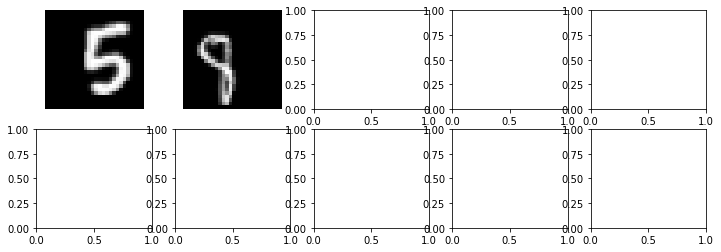

In [30]:
test = train_val_generator.next()

display_images(test[0])
print(test[1][:10])

CNN model

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.optimizers import Adam

def CNN_model(learning_rate = 0.001, drop_rate = 0.5, kernels = [32, 32]):
    adam = Adam(learning_rate = learning_rate)
    model = Sequential(name = "cnn_model")

    # Convolutional layers

    for number_kernel in kernels:
        conv_layer = Conv2D(
            number_kernel, 
            kernel_size = (3, 3), 
            activation = "relu", 
            kernel_initializer = "he_normal",
            input_shape = X_train.shape[1:]
        )
        model.add(conv_layer)
        model.add(MaxPooling2D(pool_size = (2, 2), strides = 2))
    
    # MLP layers

    model.add(Flatten())
    model.add(Dropout(drop_rate))
    model.add(Dense(256, activation = "relu", kernel_initializer = "he_normal"))
    model.add(Dense(10, activation = "softmax"))

    model.compile(loss = "sparse_categorical_crossentropy", optimizer = adam, metrics = ["acc"])

    return model

model = CNN_model(drop_rate = 0.5)
model.summary()

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Model: "cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 32)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 800)               0         
                                              

2022-04-28 18:41:04.850332: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-28 18:41:04.850596: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [12]:
steps_per_epoch = int(len(X_train_val) / 32)
validation_steps = int(len(X_val) / 32)

steps_per_epoch, validation_steps

(1562, 312)

In [13]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopper = EarlyStopping(monitor = "val_acc", mode = "max", patience = 5, restore_best_weights = True)

model.fit(
    train_val_generator,
    steps_per_epoch = steps_per_epoch,
    epochs = 3,
    callbacks = [early_stopper],
    validation_data = val_generator,
    validation_steps = validation_steps
)

Epoch 1/3


2022-04-28 18:41:34.406191: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-04-28 18:41:34.733951: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1558/1562 [============================>.] - ETA: 0s - loss: 0.5703 - acc: 0.8140

2022-04-28 18:41:50.251180: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1562/1562 [==============================] - 17s 10ms/step - loss: 0.5694 - acc: 0.8143 - val_loss: 0.1651 - val_acc: 0.9522
Epoch 2/3
1562/1562 [==============================] - 16s 10ms/step - loss: 0.2318 - acc: 0.9263 - val_loss: 0.0748 - val_acc: 0.9768
Epoch 3/3
1562/1562 [==============================] - 16s 10ms/step - loss: 0.1786 - acc: 0.9441 - val_loss: 0.0720 - val_acc: 0.9792


In [15]:
def plot_metrics(metrics):
    _, ax = plt.subplots(1, 2, figsize = (12, 4))
    metrics[["loss", "val_loss"]].plot(ax = ax[0], grid = True)
    metrics[["acc", "val_acc"]].plot(ax = ax[1], grid = True)

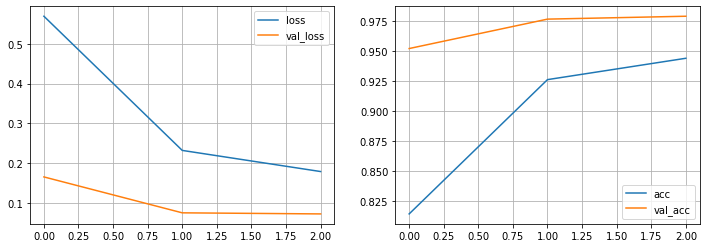

In [16]:
metrics = pd.DataFrame(model.history.history)
plot_metrics(metrics)

In [18]:
model = CNN_model()

train_generator = train_image_generator.flow(X_train, y_train, batch_size = 32)


model.fit(train_generator, steps_per_epoch = steps_per_epoch, epochs = 3)

Epoch 1/3
   5/1562 [..............................] - ETA: 20s - loss: 2.4776 - acc: 0.1562 

2022-04-28 18:44:44.569978: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1562/1562 [==============================] - 15s 9ms/step - loss: 0.5424 - acc: 0.8240
Epoch 2/3
1562/1562 [==============================] - 15s 10ms/step - loss: 0.2137 - acc: 0.9333
Epoch 3/3
1562/1562 [==============================] - 15s 9ms/step - loss: 0.1671 - acc: 0.9477


2022-04-28 18:45:39.969690: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       1.00      0.99      0.99      1135
           2       0.98      0.99      0.98      1032
           3       0.96      1.00      0.98      1010
           4       0.98      0.99      0.99       982
           5       0.99      0.97      0.98       892
           6       0.99      0.98      0.98       958
           7       0.99      0.98      0.98      1028
           8       0.98      0.98      0.98       974
           9       0.99      0.96      0.98      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



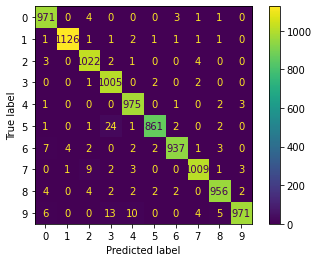

In [19]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis = 1)

print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()